In [1]:
from data.dataset import REFLACXWithClinicalDataset
from model.xami import XAMIMultiModal
import torch.nn as nn
import torch.optim as optim
import torch 
from utils.train import split_dataset, train, RecordUnit

In [2]:
# checking if the GPU is available
use_gpu = torch.cuda.is_available()

# setting up the device
device = 'cuda' if use_gpu else 'cpu'

In [3]:
# load the dataset
reflacx_dataset = REFLACXWithClinicalDataset()

# prepare the model
xami_mutlimodal = XAMIMultiModal(reflacx_dataset, device)
xami_mutlimodal = xami_mutlimodal.to(device)

Positive Loss weight:
[0.9940653  0.78635013 0.8338279  0.768546   0.9985163  1.
 0.90949553 0.99703264 0.87388724 0.99554896 0.7166172  0.99554896
 0.9703264  0.9940653  0.98219585 0.98961425 0.9718101  0.98367953
 0.9376855  0.7937685 ]
Negative Loss weight:
[0.00593472 0.21364985 0.1661721  0.231454   0.00148368 0.
 0.09050445 0.00296736 0.12611276 0.00445104 0.2833828  0.00445104
 0.02967359 0.00593472 0.01780416 0.01038576 0.02818991 0.01632047
 0.06231454 0.20623146]
Random Loss:
0.08506889533870689


In [4]:
lr = 0.0001
batch_size = 64

optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                       xami_mutlimodal.parameters()), lr=lr, weight_decay=0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 patience=1, threshold=0.001, factor=0.1)
loss_fn = nn.MultiLabelSoftMarginLoss()

In [5]:
dataloaders = split_dataset(
    reflacx_dataset,
    batch_size,
    traing_portion=.8,
    test_portion=.1,
    seed=123
)

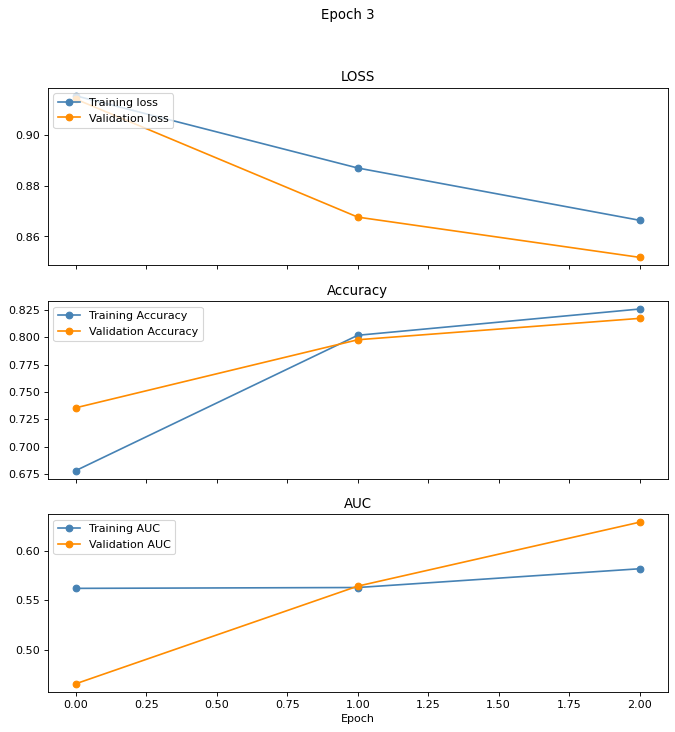

Training CM
Airway wall thickening
              Pred_False  Pred_True
Target_False         536          0
Target_True            3          0
Atelectasis
              Pred_False  Pred_True
Target_False         423          0
Target_True          114          2
Consolidation
              Pred_False  Pred_True
Target_False         451          0
Target_True           88          0
Enlarged cardiac silhouette
              Pred_False  Pred_True
Target_False         141        270
Target_True           37         91
Fibrosis
              Pred_False  Pred_True
Target_False         538          0
Target_True            1          0
Fracture
              Pred_False  Pred_True
Target_False         539          0
Target_True            0          0
Groundglass opacity
              Pred_False  Pred_True
Target_False         490          0
Target_True           49          0
Pneumothorax
              Pred_False  Pred_True
Target_False         537          0
Target_True            2        

KeyboardInterrupt: 

In [6]:
train_data, val_data = train(
    num_epochs=100,
    model=xami_mutlimodal,
    dataloaders=dataloaders,
    scheduler=scheduler,
    dataset=reflacx_dataset,
    optimizer=optimizer,
    device=device,
    early_stop_count=None,
    loss_weighted=False
)

In [ ]:
# import numpy as np
# import pandas as pd

# for idx, col in enumerate(RecordUnit.label_cols):
#     print("="*20)
#     print(col)
#     print("="*20)

#     # columns = ['Pred_False', 'Pred_True']
#     columns = []

#     # indexes = ['Target_False', 'Target_True']
#     indexes = []

#     # we do false first
#     if (~(np.array(RecordUnit.pred)[:, idx] > 0.5).astype(bool)).any():
#         columns.append("Pred_False")

#     if (np.array(RecordUnit.pred)[:, idx] > 0.5).astype(bool).any():
#         columns.append("Pred_True")

#     if (~(np.array(RecordUnit.target)[:, idx]).astype(bool)).any():
#         indexes.append("Target_False")

#     if (np.array(RecordUnit.target)[:, idx]).astype(bool).any():
#         indexes.append("Target_True")

#     # if len(columns) >= 2 or len(indexes) >= 2:
#     columns = ['Pred_False', 'Pred_True']
#     indexes = ['Target_False', 'Target_True']

#     df_cm = pd.DataFrame(RecordUnit.cms[col], columns=columns, index=indexes)
#     print(df_cm)
#     print("="*20)


Airway wall thickening
              Pred_False  Pred_True
Target_False         536          0
Target_True            3          0
Atelectasis
              Pred_False  Pred_True
Target_False           2        421
Target_True            0        116
Consolidation
              Pred_False  Pred_True
Target_False         451          0
Target_True           88          0
Enlarged cardiac silhouette
              Pred_False  Pred_True
Target_False           0        411
Target_True            0        128
Fibrosis
              Pred_False  Pred_True
Target_False         538          0
Target_True            1          0
Fracture
              Pred_False  Pred_True
Target_False         539          0
Target_True            0          0
Groundglass opacity
              Pred_False  Pred_True
Target_False         490          0
Target_True           49          0
Pneumothorax
              Pred_False  Pred_True
Target_False         537          0
Target_True            2          0
Pulmonar